In [1]:
import pandas as pd
import feather
import numpy as np
import matplotlib.pyplot as plt
from   astropy.io          import fits 
from   astropy             import units
from   astropy.coordinates import SkyCoord 

(I converted the csv to the feather format, makes it faster to load and saves a bit of space)

In [2]:
data = feather.read_dataframe('1593682216480A.feather')
data.dropna(subset=['rKmag', 'iKmag', 'rmag', 'imag'], inplace=True)
print(len(data))

1763670


Once we eliminate the entries that do not have magnitude measurements, we are left with 1763670 matches.

In [3]:
def getColumns(keys, data):
    return [np.array(data[key]) for key in keys]

def getMagnitudeMedians(channels, data):
    columnsK    = [f"{channel}Kmag" for channel in channels]
    columns     = [f"{channel}mag" for channel in channels]
    magsK       = getColumns(columnsK, data)
    mags        = getColumns(columns, data)
    magsKmedian = np.nanmedian(np.array([arr for arr in magsK]), axis=0)
    magsmedian  = np.nanmedian(np.array([arr for arr in mags]), axis=0)
    return magsKmedian, magsmedian
    
    
def fitsToSkyCoords(fitspath):
    cat = fits.getdata(fitspath)
    cat_array_ra   = np.array([e[0] for e in cat])
    cat_array_dec  = np.array([e[1] for e in cat])
    skycoord       = SkyCoord(ra=cat_array_ra*units.degree, \
                              dec=cat_array_dec*units.degree)
    return cat, skycoord

def matchCatalogues(small, bigger, threshold=1e-3):
    idx, d2d, d3d = small.match_to_catalog_sky(bigger)
    matches = np.where(d2d<threshold*units.degree)
    idx, d2d = idx[matches], d2d[matches]
    return idx, d2d

Above we defined some useful functions.


Now we also introduce a magnitude cut. Set it at 21 for now, 21.5 does not make a huge difference in numbers.

In [4]:
threshold     = 21
riKmedian, rimedian = getMagnitudeMedians(channels='ri', data=data)
bright_enough = np.where(rimedian<threshold)
data          = data.iloc[bright_enough[0]]
riKmedian, rimedian = getMagnitudeMedians(channels='ri', data=data)
ras, decs = getColumns(['_RAJ2000', '_DEJ2000'], data=data)
print(f"The data now has {len(data)} entries left.")

The data now has 1298334 entries left.


Let's cross-match the known lenses with our catalogue:

In [5]:
big_cat          = SkyCoord(ra=ras*units.degree, dec=decs*units.degree)
_, knowns_cat    = fitsToSkyCoords('lensedquasars.fits')
idx, d2d         = matchCatalogues(knowns_cat, big_cat)
print(f"{len(idx)} out of the {len(knowns_cat)} known lenses can be found in our catalogue.")
knowns_dataframe = data.iloc[idx]

166 out of the 219 known lenses can be found in our catalogue.


166 known lenses are found in the catalogue. This means basically all of them in the area that Pan-STARRS covers.


Now we see if we can discriminate lenses by estimating their extent. We do this by comparing the PSF-estimated and KRON-estimate magnitudes.

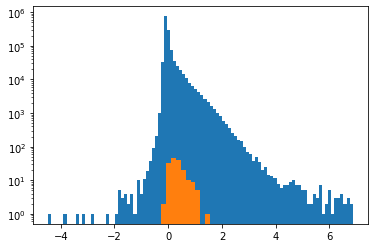

In [6]:
riKmedian_known, rimedian_known = getMagnitudeMedians(channels='ri', data=knowns_dataframe)

plt.hist(rimedian-riKmedian, bins=100)
plt.hist(rimedian_known-riKmedian_known)
plt.yscale('log')

I don't see something particularly useful with the above, but I am not sure I really undertood what the good strategy was.


Now we will try to find all the miliquas elements that have multiple Pan-STARRS detections.
We know that the most widely separated known QSO has separation ~0.007 degrees, thus we will use this value as a threshold for the search.
Unfortunately, I don't know how to do this without using a for loop. I hope it won't take too long.
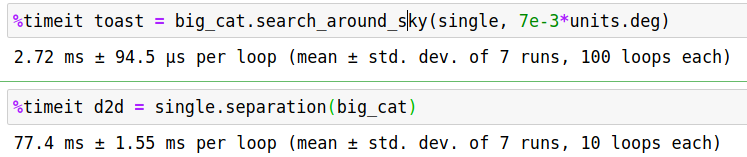
It is much faster to use astropy's search_around_sky, even though it does not work for single points. We will artificially introduce the (0,0) point every time to make the algorithm happy.

In [7]:
import pickle
try:
    with open('multiples.pickle', 'rb') as f:
        ids_multiple = pickle.load(f)
except FileNotFoundError:
    a = input("Dictionary pickle not found. Redo? (y/n)")
    if a=='y':
        from ipywidgets import IntProgress
        from IPython.display import display
        max_count = len(data)


        f = IntProgress(min=0, max=max_count) # instantiate the bar
        display(f) # display the bar


        ids_multiple = {}
        threshold = 6e-3 * units.degree
        for index in range(max_count):
            ra, dec = ras[index], decs[index]
            single = SkyCoord(ra=np.array([0,ra])*units.degree, dec=np.array([0,dec])*units.degree)
            _, idxbigcat, d2d, _ = big_cat.search_around_sky(single, threshold)
            if len(idxbigcat)>1:
                ids_multiple[index] = idxbigcat

            f.value += 1
            if index % 1000 == 0:
                # Store data (serialize)
                with open('multiples.pickle', 'wb') as handle:
                    pickle.dump(ids_multiple, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        raise FileNotFoundError

The cross matching above took ~30min. Guess it would be faster with some clustering algorithm but it's fine for now.


Now, extract the unique multiplets from the dictionary we created:

In [8]:
multiplets = []
for ids, multiplet in ids_multiple.items():
    multiplet = list(multiplet)
    if not multiplet in multiplets:
        multiplets.append(multiplet)
    

And insert them in a new frame for convenience:

In [9]:
ras_newframe = []
decs_newframe = []
mainids_newframe = []
for multiplet in multiplets:
    ras_mult, decs_mult = [], []
    for detection in multiplet[::-1]:
        row = data.iloc[detection]
        ras_mult.append(row['_RAJ2000']), decs_mult.append(row['_DEJ2000'])
    ra, dec = np.mean(ras_mult), np.mean(decs_mult)
    ras_newframe.append(ra)
    decs_newframe.append(dec)
    mainids_newframe.append(detection)
    
multiplets_frame = {
    'iloc':mainids_newframe,
    '_RAJ2000':ras_newframe,
    '_DEJ2000':decs_newframe,
    'ilocs':multiplets
}
multiplets_frame = pd.DataFrame(multiplets_frame, 
                                columns=['iloc', '_RAJ2000', '_DEJ2000', 'ilocs'])
multiplets_frame

iloc    _RAJ2000   _DEJ2000               ilocs
0          145    0.036468  47.983010          [145, 146]
1          362    0.083177  -4.841805          [362, 363]
2          508    0.115222  14.940200          [508, 509]
3          633    0.149339   5.537414          [633, 634]
4          662    0.154868 -11.035447          [662, 663]
...        ...         ...        ...                 ...
27825  1298158  359.963057  -1.581210  [1298158, 1298183]
27826  1298177  359.964848  25.004898  [1298177, 1298178]
27827  1298197  359.968089   2.559058  [1298197, 1298198]
27828  1298256  359.983326 -25.610398  [1298256, 1298257]
27829  1298332  359.999955  34.747133  [1298332, 1298333]

[27830 rows x 4 columns]

where the 'iloc' column can be used to access the original elements in the 'data' dataframe:

     element = data.iloc[iloc]


Match all these entries with the known lenses, to see if we recover at least some of them:

In [10]:
multiplets_coords = SkyCoord(ra=multiplets_frame['_RAJ2000']*units.deg,
                             dec=multiplets_frame['_DEJ2000']*units.deg)
idx, d2d = matchCatalogues(knowns_cat, multiplets_coords, threshold=1e-3)
print(f"The {len(multiplets_coords)} multiplets contain {len(idx)} of the {len(knowns_cat)} known lenses.")

The 27830 multiplets contain 70 of the 219 known lenses.


Here are a few of them:

In [11]:
multiplets_frame.iloc[idx]

iloc    _RAJ2000   _DEJ2000                         ilocs
225      12224    2.834349  -8.764081         [12224, 12225, 12226]
616      31801    7.093786   6.531577  [31801, 31802, 31806, 31807]
652      34096    7.563829 -15.417836                [34096, 34097]
1069     54795   11.946715  25.241057                [54795, 54796]
1605     85292   18.659754   7.374702                [85292, 85294]
...        ...         ...        ...                           ...
24548  1152840  321.070280  16.538136   [1152840, 1152841, 1152842]
25019  1169243  326.691842  -0.795636            [1169243, 1169244]
26703  1241171  346.105638 -22.246395            [1241171, 1241172]
26736  1242575  346.482726  37.239314            [1242575, 1242576]
27263  1268803  353.080285 -18.868537   [1268803, 1268804, 1268805]

[70 rows x 4 columns]